In [38]:
import sys
import pandas as pd
import numpy as np
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
from sklearn.model_selection import train_test_split
import random
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
#import mae and rmse
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import implicit

# Load the data like we did before
raw_data = pd.read_csv('data_100.csv')
raw_data.columns = ['user', 'artist', 'plays']

# Drop NaN columns
data = raw_data.dropna()
data = data.copy()

# Create a numeric user_id and artist_id column
data['user'] = data['user'].astype("category")
data['artist'] = data['artist'].astype("category")
data['user_id'] = data['user'].cat.codes
data['artist_id'] = data['artist'].cat.codes

# Split the data into training and test sets
train_data, test_data = train_test_split(data, test_size=0.2)

# The implicit library expects data as an item-user matrix, so we
# create two matrices: one for fitting the model (item-user) 
# and one for recommendations (user-item)
sparse_item_user_train = sparse.csr_matrix((train_data['plays'].astype(float), (train_data['artist_id'], train_data['user_id'])))
sparse_item_user_test = sparse.csr_matrix((test_data['plays'].astype(float), (test_data['artist_id'], test_data['user_id'])))

sparse_user_item_train = sparse.csr_matrix((train_data['plays'].astype(float), (train_data['user_id'], train_data['artist_id'])))
sparse_user_item_test = sparse.csr_matrix((test_data['plays'].astype(float), (test_data['user_id'], test_data['artist_id'])))


# Initialize the als model and fit it using the sparse item-user matrix
model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=100)

# Calculate the confidence by multiplying it by our alpha value.
alpha_val = 200
data_conf = (sparse_item_user_train * alpha_val).astype('double')

#Fit the model
model.fit(data_conf)

  0%|          | 0/100 [00:00<?, ?it/s]

In [48]:
user_id = 1
recommended = model.recommend(userid=user_id, user_items=sparse_item_user_test[user_id], N=10)

actual_ratings = []
predicted_ratings = []

for artist_id in recommended[0]:
    # Find the corresponding score in the data DataFrame
    data_score = data.loc[data['artist_id'] == artist_id, 'plays'].iloc[0]
    # Find the corresponding score in the recommended list
    recommended_index = np.where(recommended[0] == artist_id)[0]
    recommended_score = recommended[1][recommended_index][0] * 10
    actual_ratings.append(data_score)
    predicted_ratings.append(recommended_score)

    
#Compute evaluation metrics

mae = mean_absolute_error(actual_ratings, predicted_ratings)
rmse = mean_squared_error(actual_ratings, predicted_ratings, squared=False)

print("MAE:", mae)
print("RMSE:", rmse)

#0
# MAE: 3.798862338066101
# RMSE: 4.32345813676019

#10
# MAE: 3.3171573162078856
# RMSE: 4.022039334812764

#60
# MAE: 3.7572234153747557
# RMSE: 4.146754304240269

#100
# MAE: 4.3
# RMSE: 5.300943312279429

MAE: 4.3
RMSE: 5.300943312279429


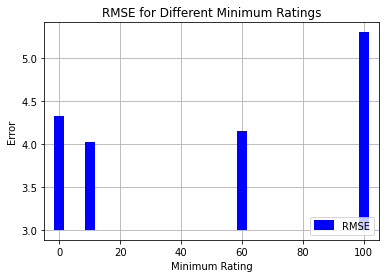

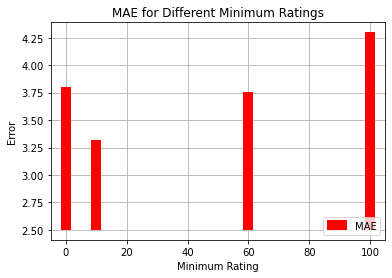

In [49]:
import matplotlib.pyplot as plt

x = [0, 10, 60, 100]
mae = [3.798862338066101, 3.3171573162078856, 3.7572234153747557, 4.3]
rmse = [4.32345813676019, 4.022039334812764, 4.146754304240269, 5.300943312279429]

plt.vlines(x, 3, rmse, colors='blue', linewidth=10, label='RMSE')
plt.xlabel('Minimum Rating')
plt.ylabel('Error')
plt.title('RMSE for Different Minimum Ratings')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

plt.vlines(x, 2.5, mae, colors='red', linewidth=10, label='MAE')
plt.xlabel('Minimum Rating')
plt.ylabel('Error')
plt.title('MAE for Different Minimum Ratings')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
